# < K리그 패스 좌표 예측 - 초기 데이터 탐색 > 

- **목표**: 데이터 구조 파악 및 기본 통계 확인
- **날짜**: 2025-12-11
- **작성자**: polarsnow09

## 1. 환경설정 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# 한글 폰트 설정 (Windows)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 경로 설정
DATA_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')

In [3]:
# 데이터 파일 확인 및 크기 출력
print("📂 사용 가능한 데이터 파일:")
for file in DATA_DIR.glob('*.csv'):
    size = file.stat().st_size / 1024 / 1024  # MB
    print(f"  - {file.name}: {size:.2f} MB")

📂 사용 가능한 데이터 파일:
  - match_info.csv: 0.03 MB
  - sample_submission.csv: 0.05 MB
  - test.csv: 0.10 MB
  - train.csv: 41.54 MB


## 2. Data loading

In [4]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
match_info = pd.read_csv(DATA_DIR / 'match_info.csv')
sample_submission = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print("✅ 데이터 로딩 완료")
print(f"  - Train: {train.shape}")
print(f"  - Test: {test.shape}")
print(f"  - Match Info: {match_info.shape}")

✅ 데이터 로딩 완료
  - Train: (356721, 15)
  - Test: (2414, 3)
  - Match Info: (228, 17)


## 3. 기본 정보 확인

In [8]:
# Train 데이터 구조
print("🔍 Train 데이터 미리보기:")
display(train.head())
print("\n🎇컬럼 정보:")
display(train.info())

🔍 Train 데이터 미리보기:


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1



🎇컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356721 entries, 0 to 356720
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   game_id       356721 non-null  int64  
 1   period_id     356721 non-null  int64  
 2   episode_id    356721 non-null  int64  
 3   time_seconds  356721 non-null  float64
 4   team_id       356721 non-null  int64  
 5   player_id     356721 non-null  int64  
 6   action_id     356721 non-null  int64  
 7   type_name     356721 non-null  object 
 8   result_name   216467 non-null  object 
 9   start_x       356721 non-null  float64
 10  start_y       356721 non-null  float64
 11  end_x         356721 non-null  float64
 12  end_y         356721 non-null  float64
 13  is_home       356721 non-null  bool   
 14  game_episode  356721 non-null  object 
dtypes: bool(1), float64(5), int64(6), object(3)
memory usage: 38.4+ MB


None

In [9]:
# 결측치 확인
print("❓ 결측치 현황:")
missing = train.isnull().sum()
missing_pct = 100 * missing / len(train)
missing_df = pd.DataFrame({
    '결측치 개수': missing,
    '비율(%)': missing_pct
})
display(missing_df[missing_df['결측치 개수'] > 0])

❓ 결측치 현황:


,결측치 개수,비율(%)
result_name,140254,39.317562


## 4. 타겟 변수 확인

In [10]:
# 예측 대상 확인 (sample_submission 구조 체크)
print("🎯 제출 형식:")
display(sample_submission.head())

🎯 제출 형식:


,game_episode,end_x,end_y
0,153363_1,50.0,50.0
1,153363_2,50.0,50.0
2,153363_6,50.0,50.0
3,153363_7,50.0,50.0
4,153363_8,50.0,50.0


## 5. 좌표 데이터 기본 탐색

In [12]:
# 좌표 범위 확인
print("📍 좌표 범위:")
print(f"start_x: {train['start_x'].min():.2f} ~ {train['start_x'].max():.2f}")
print(f"start_y: {train['start_y'].min():.2f} ~ {train['start_y'].max():.2f}")
print(f"end_x: {train['end_x'].min():.2f} ~ {train['end_x'].max():.2f}")
print(f"end_y: {train['end_y'].min():.2f} ~ {train['end_y'].max():.2f}")

📍 좌표 범위:
start_x: 0.00 ~ 105.00
start_y: 0.00 ~ 68.00
end_x: 0.00 ~ 105.00
end_y: 0.00 ~ 68.00


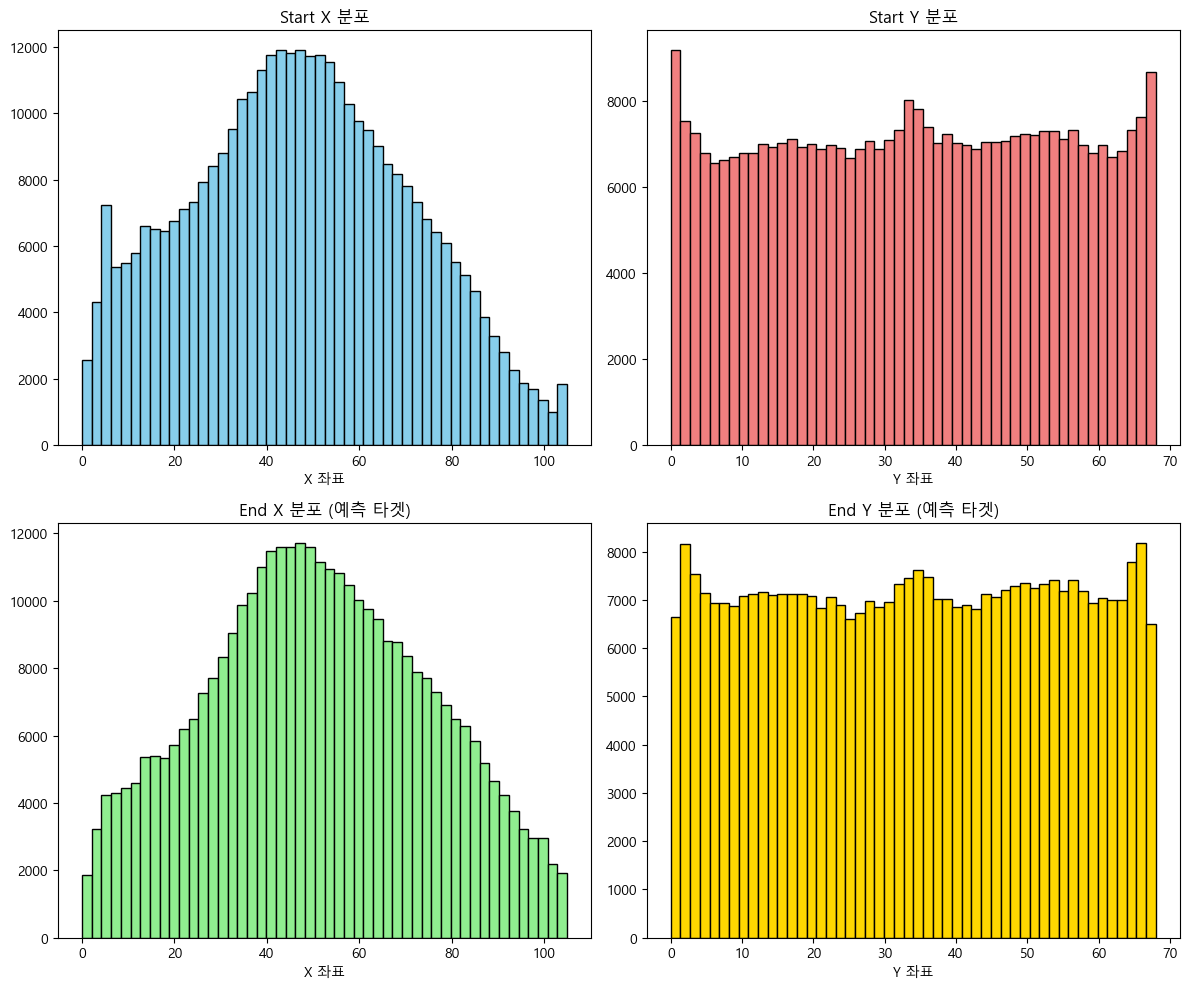

In [14]:
# 좌표 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Start X
axes[0, 0].hist(train['start_x'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Start X 분포')
axes[0, 0].set_xlabel('X 좌표')

# Start Y
axes[0, 1].hist(train['start_y'].dropna(), bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Start Y 분포')
axes[0, 1].set_xlabel('Y 좌표')

# End X
axes[1, 0].hist(train['end_x'].dropna(), bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('End X 분포 (예측 타겟)')
axes[1, 0].set_xlabel('X 좌표')

# End Y
axes[1, 1].hist(train['end_y'].dropna(), bins=50, color='gold', edgecolor='black')
axes[1, 1].set_title('End Y 분포 (예측 타겟)')
axes[1, 1].set_xlabel('Y 좌표')

plt.tight_layout()
plt.savefig('../reports/figures/coordinate_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

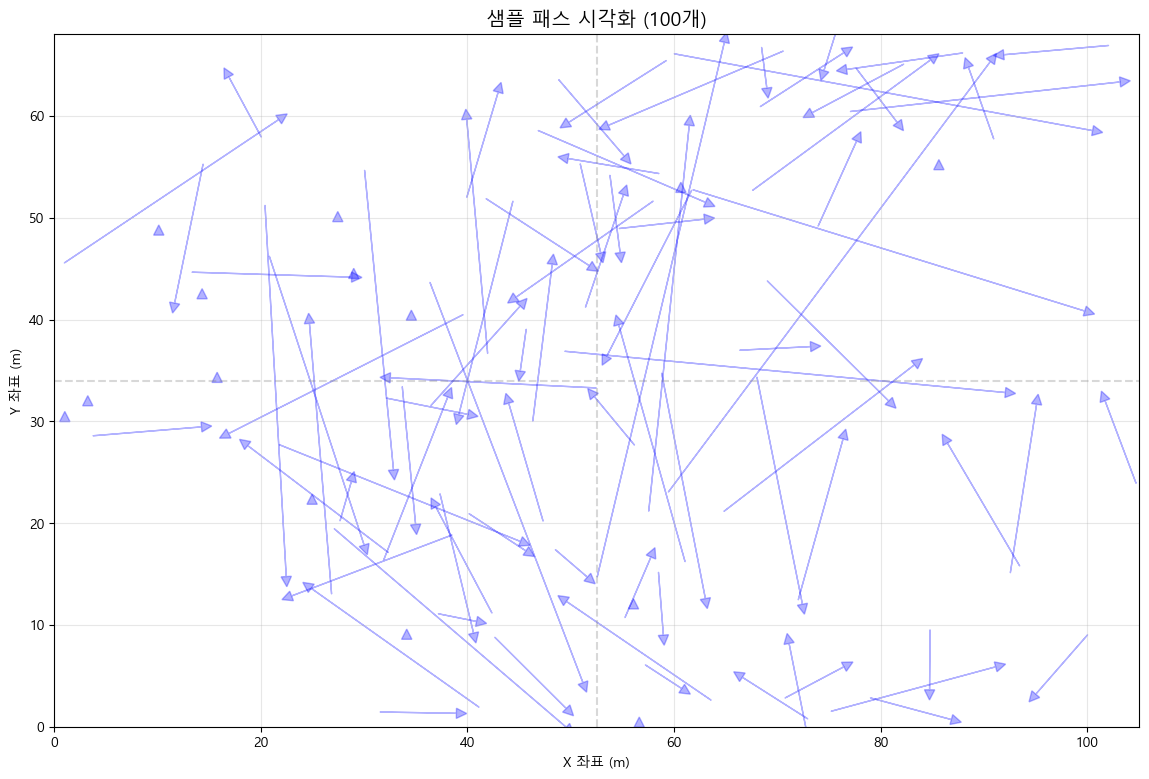

In [15]:
# 패스 시각화 (샘플 100개)
plt.figure(figsize=(14, 9))

# 경기장 그리기 (추정: 105m x 68m)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.axhline(y=34, color='gray', linestyle='--', alpha=0.3, label='중앙선')
plt.axvline(x=52.5, color='gray', linestyle='--', alpha=0.3)

# 랜덤 샘플 100개 패스 그리기
sample_passes = train.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y']).sample(100)

for idx, row in sample_passes.iterrows():
    plt.arrow(row['start_x'], row['start_y'], 
              row['end_x'] - row['start_x'], 
              row['end_y'] - row['start_y'],
              head_width=1, head_length=1, fc='blue', ec='blue', alpha=0.3)

plt.title('샘플 패스 시각화 (100개)', fontsize=14)
plt.xlabel('X 좌표 (m)')
plt.ylabel('Y 좌표 (m)')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/pass_visualization_sample.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 범주형 변수 탐색

⚽ 액션 타입 분포:
type_name
Pass                178582
Carry                82046
Recovery             27352
Interception         11088
Duel                  8734
Tackle                8138
Throw-In              6801
Clearance             6563
Intervention          6038
Block                 3983
Pass_Freekick         3824
Cross                 3589
Goal Kick             2713
Error                 1647
Shot                  1413
Pass_Corner           1137
Catch                 1019
Take-On                987
Aerial Clearance       478
Parry                  373
Hit                    130
Shot_Freekick           43
Foul                    26
Deflection              14
Penalty Kick             2
Handball_Foul            1
Name: count, dtype: int64


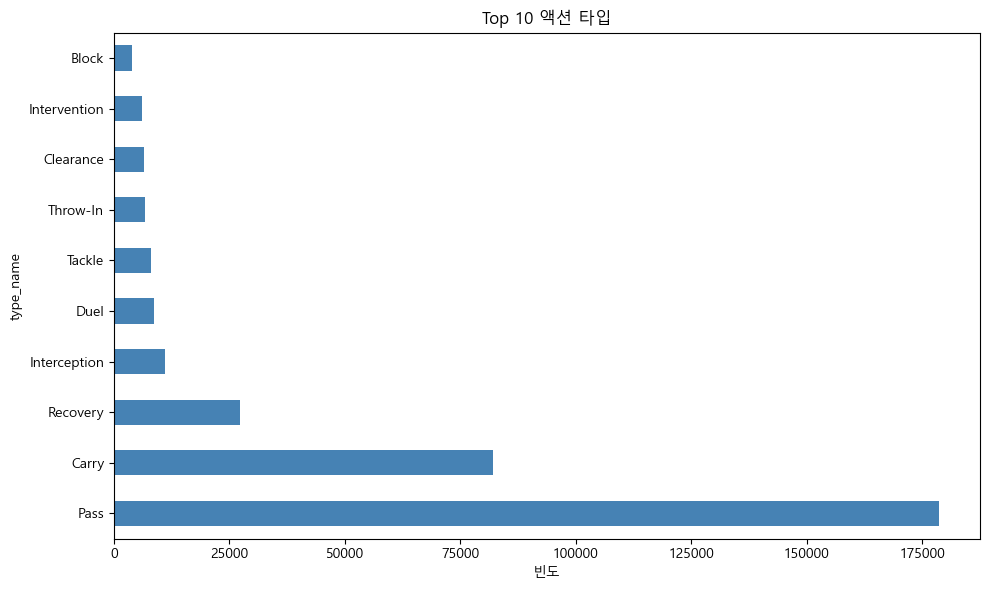

In [16]:
# type_name 분포 (패스 종류)
print("⚽ 액션 타입 분포:")
print(train['type_name'].value_counts())

plt.figure(figsize=(10, 6))
train['type_name'].value_counts().head(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 액션 타입')
plt.xlabel('빈도')
plt.tight_layout()
plt.savefig('../reports/figures/action_type_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# result_name 분포 (성공/실패)
print("\n✅ 액션 결과 분포:")
print(train['result_name'].value_counts())


✅ 액션 결과 분포:
result_name
Successful          178537
Unsuccessful         36446
On Target              692
Blocked                635
Low Quality Shot        71
Off Target              48
Yellow_Card             26
Keeper Rush-Out         12
Name: count, dtype: int64


In [18]:
# game_episode 확인 (test 데이터와 매칭)
print(f"\n🎮 총 에피소드 수: {train['game_episode'].nunique()}")
print(f"게임 수: {train['game_id'].nunique()}")
print(f"평균 에피소드당 액션: {len(train) / train['game_episode'].nunique():.1f}")


🎮 총 에피소드 수: 15435
게임 수: 198
평균 에피소드당 액션: 23.1
